In [15]:
import xml.etree.ElementTree as ET
import pathlib
from pathlib import Path
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
import torch
from matplotlib import pyplot as plt
from torchvision import transforms
from natsort import natsorted
import cv2
import numpy as np
import random

from sklearn.model_selection import train_test_split

In [2]:
image_dir = Path(os.getcwd() + "/../data/images")
annotations_dir = Path(os.getcwd()+"/../data/annotations")
image_dir, annotations_dir

(PosixPath('/workspace/projects/vision/face-mask-detection/notebooks/../data/images'),
 PosixPath('/workspace/projects/vision/face-mask-detection/notebooks/../data/annotations'))

In [3]:
def parse_xml(xml_file):
    # Get xml tree root
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Get all "ojbect" tags in the file
    objects = root.findall('object')
    # Get annotations which contain all labels and boundboxes
    object_annotations = []
    for obj in objects:
        # Get bound box coords and labels for each face in the image
        label = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)

        object_annotations.append({
            'label(s)': label,
            'bbox(s)': [xmin, ymin, xmax, ymax]
        })
    return object_annotations

## 1. Creating a `torch.utils.data` Dataset and Visualizing Images, bboxes and labels

In [4]:
class FaceMaskDataset(Dataset):
    def __init__(self, image_dir, annotations_dir, transform= None):
        super().__init__()
        # Getting a sorted list of all image and annotations file names
        self.image_paths = natsorted(list(pathlib.Path(image_dir).glob("*.png")))
        self.annotation_paths = natsorted(list(pathlib.Path(annotations_dir).glob("*.xml")))

        # Getting transforms if found
        self.transform = transform
        # class_to_idx will be used when training a model
        self.class_to_idx = {"with_mask": 0, "without_mask": 1, "mask_weared_incorrect": 2}
        self.classes = ["with_mask", "without_mask", "mask_weared_incorrect"] 

    # Overriding the __getitem__() function to return a PIL image and its associated annotations
    def __getitem__(self, idx: int):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        image = image.convert("RGB")
        object_annotations = parse_xml(self.annotation_paths[idx])

        if self.transform:
            original_width, original_height = image.size
            image = self.transform(image)
            new_width, new_height = image.shape[1], image.shape[2]
            width_scale= new_width / original_width
            height_scale= new_height / original_height
            
            for annotation in object_annotations:
                xmin, ymin, xmax, ymax = annotation['bbox(s)']
                annotation['bbox(s)'] = [
                    int(xmin * width_scale),
                    int(ymin * height_scale),
                    int(xmax * width_scale),
                    int(ymax * height_scale)
                ]
                label = annotation['label(s)']
                annotation['label(s)'] = torch.tensor(self.class_to_idx[label], dtype= torch.int64)
                annotation['bbox(s)'] = torch.tensor(annotation['bbox(s)'], dtype= torch.float32)


            return image, object_annotations
        else:
            return image, object_annotations


    def __len__(self) -> int:
        if len(self.image_paths) == len(self.annotation_paths): 
            return len(self.image_paths)
        else:
            print("Error num of images != num of annotations \n")
            return -1

In [5]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size= (448, 448))
])

In [6]:
all_data = FaceMaskDataset(image_dir, annotations_dir, transform= train_transforms)

In [7]:
data = all_data.__getitem__(5)
ann_test = data[1]
ann_test


[{'label(s)': tensor(0), 'bbox(s)': tensor([132.,  90., 180., 161.])},
 {'label(s)': tensor(1), 'bbox(s)': tensor([407.,  50., 449., 111.])},
 {'label(s)': tensor(1), 'bbox(s)': tensor([215., 178., 256., 242.])},
 {'label(s)': tensor(0), 'bbox(s)': tensor([278., 160., 325., 234.])}]

/tmp/ipykernel_842/2553516905.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np_image = np.array(tensor_image).copy()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


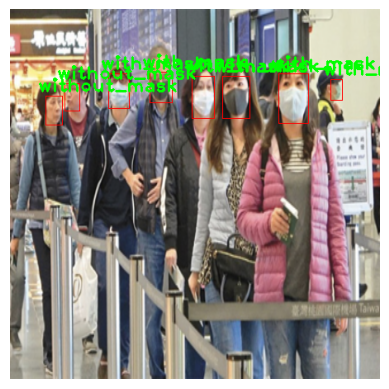

In [128]:
def visualize_random_image_with_bbox(dataset: Dataset):
    index = random.randrange(1, dataset.__len__() - 1)
    data = dataset.__getitem__(index)
    
    # Permute tensor image for the preferred shape by opencv (C,H,W) -> (H,W,C)
    tensor_image, image_annotations = data[0], data[1]
    tensor_image = torch.permute(tensor_image, (1, 2, 0))
    
    np_image = np.array(tensor_image).copy()
    opencv_image = np_image



    for ann in image_annotations:
        label_int = ann['label(s)'].item()
        label_txt = dataset.classes[label_int]
        bbox = ann['bbox(s)']

        xmin, ymin, xmax, ymax = int(bbox[0].item()), int(bbox[1].item()), int(bbox[2].item()), int(bbox[3].item())
        cv2.rectangle(img= opencv_image,
                      pt1= (xmin,ymin),
                      pt2= (xmax,ymax),
                      color= (255, 0, 0),
                      shift= 0)
        cv2.putText(img= opencv_image,
                    text= label_txt,
                    org= (xmin - 10, ymin - 5),
                    fontFace= cv2.FONT_HERSHEY_PLAIN,
                    fontScale= 1.5,
                    color= (0, 255, 0),
                    thickness= 2)
    
    plt.imshow(opencv_image)
    plt.axis(False)

visualize_random_image_with_bbox(all_data)
        

In [9]:
dataset = FaceMaskDataset(image_dir= image_dir, annotations_dir= annotations_dir, transform= train_transforms)

train_dataset, test_dataset = train_test_split(dataset, train_size= 0.80, random_state= 42)
train_dataset.__len__(), test_dataset.__len__()

(682, 171)

In [10]:
def custom_collate_fn(batch):
    return tuple(zip(*batch))

In [66]:
train_dataloader = DataLoader(train_dataset,
                              batch_size= 2,
                              shuffle= True,
                              num_workers= 0,
                              collate_fn= custom_collate_fn)
test_dataloader = DataLoader(test_dataset,
                             batch_size= 2,
                             shuffle= False,
                             num_workers= 0,
                             collate_fn= custom_collate_fn)
images, annotations = next(iter(train_dataloader))
images[0].shape, annotations[1]

(torch.Size([3, 448, 448]),
 [{'label(s)': tensor(0), 'bbox(s)': tensor([ 89., 102., 129., 167.])},
  {'label(s)': tensor(0), 'bbox(s)': tensor([255.,  70., 291., 134.])},
  {'label(s)': tensor(0), 'bbox(s)': tensor([340.,  78., 379., 140.])},
  {'label(s)': tensor(1), 'bbox(s)': tensor([151., 115., 174., 151.])},
  {'label(s)': tensor(1), 'bbox(s)': tensor([ 39., 115.,  61., 152.])}])

In [23]:
classes = ["with_mask", "without_mask", "mask_weared_incorrect"] 

## Testing out dataloaders

/tmp/ipykernel_842/3868668779.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  np_image = np.array(tensor_image).copy()
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


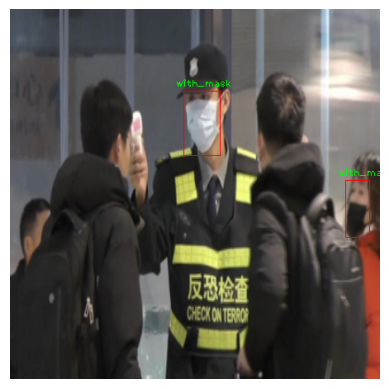

In [130]:
def visualize_image_dataloader(dataset: Dataset, dataloader: DataLoader, idx: int, classes= classes):
    images, annotations = next(iter(dataloader))

    tensor_image, image_annotations = images[idx], annotations[idx]
    tensor_image = torch.permute(tensor_image,(1, 2, 0))

    np_image = np.array(tensor_image).copy()

    opencv_image = np_image

    for ann in image_annotations:
        label_int = ann['label(s)'].item()
        label_txt = classes[label_int]
        bbox = ann['bbox(s)']

        xmin, ymin, xmax, ymax = int(bbox[0].item()), int(bbox[1].item()), int(bbox[2].item()), int(bbox[3].item())
        cv2.rectangle(img= opencv_image,
                      pt1= (xmin,ymin),
                      pt2= (xmax,ymax),
                      color= (255, 0, 0),
                      shift= 0)
        cv2.putText(img= opencv_image,
                    text= label_txt,
                    org= (xmin - 10, ymin - 5),
                    fontFace= cv2.FONT_HERSHEY_PLAIN,
                    fontScale= 0.8,
                    color= (0, 255, 0),
                    thickness= 1)
    
    plt.imshow(opencv_image)
    plt.axis(False)

visualize_image_dataloader(dataset= data, dataloader= train_dataloader, idx= 1)



In [97]:
image, annotations = next(iter(train_dataloader))
for i in range(annotations.__len__()):
    annotations_per_image = annotations[i]
    for ann in annotations_per_image:
        print(ann['bbox(s)'])
    

tensor([ 43., 123., 166., 322.])
tensor([267., 141., 412., 350.])
tensor([ 77., 129., 119., 184.])
tensor([213., 118., 247., 171.])
tensor([348., 129., 387., 177.])
tensor([  3.,  85.,  25., 124.])
tensor([120.,  79., 150., 108.])


In [115]:
boxes= []
labels= []
for i in range(0, annotations.__len__()):
    annotations_image_batch = annotations[i]
    for annotation in annotations_image_batch:
        boxes.append(annotation['bbox(s)'])
        labels.append(annotation['label(s)'])

boxes, annotations[1]

([tensor([ 43., 123., 166., 322.]),
  tensor([267., 141., 412., 350.]),
  tensor([ 77., 129., 119., 184.]),
  tensor([213., 118., 247., 171.]),
  tensor([348., 129., 387., 177.]),
  tensor([  3.,  85.,  25., 124.]),
  tensor([120.,  79., 150., 108.])],
 [{'label(s)': tensor(0), 'bbox(s)': tensor([ 77., 129., 119., 184.])},
  {'label(s)': tensor(0), 'bbox(s)': tensor([213., 118., 247., 171.])},
  {'label(s)': tensor(0), 'bbox(s)': tensor([348., 129., 387., 177.])},
  {'label(s)': tensor(1), 'bbox(s)': tensor([  3.,  85.,  25., 124.])},
  {'label(s)': tensor(0), 'bbox(s)': tensor([120.,  79., 150., 108.])}])

In [142]:
def convert_ann_to_yolo_targ(annotations, image_size, S= 7, B= 2, C= 3):

    boxes= []
    labels= []
    
    for i in range(annotations.__len__()):
        annotations_image_batch = annotations[i]
        for annotation in annotations_image_batch:
            boxes.append(annotation['bbox(s)'])
            labels.append(annotation['label(s)'])
        
    target = torch.zeros(S, S, B*5 + C)
    cell_size = image_size / S

    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box

        x_center = (xmin + xmax) / 2
        y_center = (ymin + ymax) / 2

        width= xmax - xmin
        height= ymax - ymin

        grid_x = int(x_center // cell_size)
        grid_y = int(y_center // cell_size)


        x_cell= (x_center % cell_size) / cell_size
        y_cell= (y_center % cell_size) / cell_size

        width_cell= width / image_size
        height_cell= height / image_size

        class_vec = torch.zeros(C)
        class_vec[label]= 1

        target[grid_y, grid_x, :5*B]= torch.cat([torch.tensor([x_cell, y_cell, width_cell, height_cell, 1])] * B)
        target[grid_y, grid_x, 5*B:]= class_vec

    return target

convert_ann_to_yolo_targ(annotations, 448, S= 7, B= 2, C= 3)[1][2][10]



tensor(1.)